In [3]:
#!/usr/bin/env python
# coding:utf-8
 
import os
from lxml.etree import Element, SubElement, tostring, parse, XMLParser
import pprint
from xml.dom.minidom import parseString


def write_to_xml(path, folder, filename, obj_class, x1, y1, x2, y2, img_w, img_h, img_d):
    path_file =  "annotations/" + filename + ".xml"
    if os.path.exists(path_file):
        parser = XMLParser(remove_blank_text=True)
        temp = parse(path_file, parser)
        node_root = temp.getroot()
    else:
        node_root = Element('annotation')
 
        node_folder = SubElement(node_root, 'folder')
        node_folder.text = folder
        node_filename = SubElement(node_root, 'filename')
        node_filename.text = filename+'.jpg'
        node_path = SubElement(node_root, 'path')
        node_path.text = path

        node_source = SubElement(node_root, 'source')
        node_database = SubElement(node_source, 'database')
        node_database.text = 'UECfood256'

        node_size = SubElement(node_root, 'size')
        node_width = SubElement(node_size, 'width')
        node_width.text = img_w
        node_height = SubElement(node_size, 'height')
        node_height.text = img_h
        node_depth = SubElement(node_size, 'depth')
        node_depth.text = img_d

        node_segmented = SubElement(node_root, 'segmented')
        node_segmented.text = '0'

    node_object = Element('object')
        
    node_name = SubElement(node_object, 'name')
    node_name.text = obj_class
    
    node_pose = SubElement(node_object, 'pose')
    node_pose.text = 'Unspecified'
    node_truncated = SubElement(node_object, 'truncated')
    node_truncated.text = '0'
    node_difficult = SubElement(node_object, 'difficult')
    node_difficult.text = '0'


    node_bndbox = SubElement(node_object, 'bndbox')
    node_xmin = SubElement(node_bndbox, 'xmin')
    node_xmin.text = x1
    node_ymin = SubElement(node_bndbox, 'ymin')
    node_ymin.text = y1
    node_xmax = SubElement(node_bndbox, 'xmax')
    node_xmax.text = x2
    node_ymax = SubElement(node_bndbox, 'ymax')
    node_ymax.text = y2
        
    node_root.append(node_object)
 
    xml = tostring(node_root, pretty_print=False)
    dom = parseString(xml)

    f = open(path_file, "wb")
    f.write(dom.toprettyxml(indent='\t', encoding='utf-8'))
    f.close()
    
def find_category(current):
    category = open('food_data/category.txt', "r")

    lines = category.readlines()

    for i in lines:
        i = i.strip()
        id=i.split('\t')[0]
        name = i.split('\t')[1]
        if(id==str(current)):
            return name;

In [4]:
from PIL import Image
# Iterate 10 class, i.e., folder
food_data_classes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for current in food_data_classes:
    anno_path = f"food_data/{str(current)}"

    bb = open( f"{anno_path}/bb_info.txt", "r")
    lines = bb.readlines()

    for line in lines:
        line = line.strip()
        name=line.split(' ')[0]
        x1=line.split(' ')[1]
        y1=line.split(' ')[2]
        x2=line.split(' ')[3]
        y2=line.split(' ')[4]

        # path of image
        path = f"{anno_path}/{name}.jpg"
        # folder of class 
        folder = str(current)
        filename = name

        obj_class = find_category(current)

        if(name!="img"):
            img = Image.open(path)
            img_w, img_h= img.size
            img_d = 3
            write_to_xml(path, folder, filename, str(obj_class), x1, y1, x2, y2, str(img_w), str(img_h), str(img_d) )
            
def find_category(current):
    category = open('food_data/category.txt', "r")

    lines = category.readlines()

    for i in lines:
        i = i.strip()
        id=i.split('\t')[0]
        name = i.split('\t')[1]
        if(id==str(current)):
            return name;

In [5]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET


def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                      root.find('path').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'path', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax', ]
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


def convert_annotations_xml_to_csv():
    image_path = os.path.join(os.getcwd(), 'annotations')
    xml_df = xml_to_csv(image_path)
    xml_df.to_csv('food_data.csv', index=None)
    print('Successfully converted xml to csv.')

convert_annotations_xml_to_csv()

Successfully converted xml to csv.


In [8]:
import cv2
import pandas as pd
from PIL import Image

full_labels = pd.read_csv('food_data.csv')
full_labels.size
full_labels.head()

,filename,path,width,height,class,xmin,ymin,xmax,ymax
0,1.jpg,food_data/1/1.jpg,800,600,rice,0,143,370,486
1,10.jpg,food_data/1/10.jpg,700,467,rice,71,16,478,328
2,10571.jpg,food_data/6/10571.jpg,360,480,fried chicken,1,24,358,477
3,10572.jpg,food_data/1/10572.jpg,360,480,rice,0,49,360,420
4,10586.jpg,food_data/1/10586.jpg,360,480,rice,19,69,355,372


In [9]:
full_labels['class'].value_counts()

rice             626
green salad      350
hamburger        242
sandwiches       164
french fries     156
fried chicken    154
pizza            134
croissant        121
simmered pork    109
steak            108
Name: class, dtype: int64

In [10]:
def draw_boxes(image_name):
    selected_value = full_labels[full_labels.filename == image_name]
    # cv2 open image in BRG
    BGR_img = cv2.imread(selected_value.iloc[0]['path'])
    for index, row in selected_value.iterrows():
        BGR_img = cv2.rectangle(BGR_img, (row['xmin'], row['ymin']), (row['xmax'], row['ymax']), (0, 255, 0), 2)
    # convert BGR to RGB before showing
    RGB_img = cv2.cvtColor(BGR_img, cv2.COLOR_BGR2RGB)
    return RGB_img

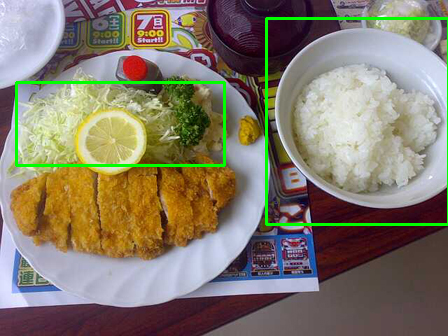

In [11]:
Image.fromarray(draw_boxes('37.jpg'))

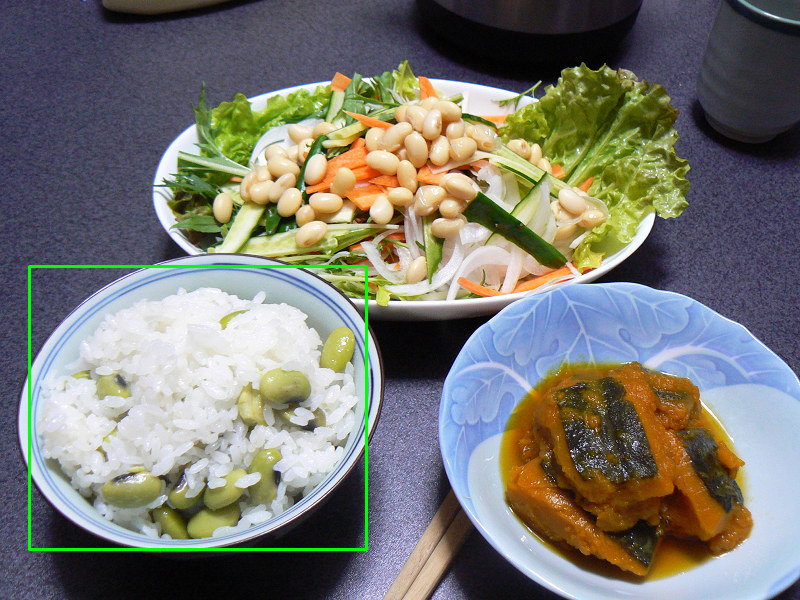

In [11]:
Image.fromarray(draw_boxes('96.jpg'))

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

train_inds, test_inds = next(StratifiedShuffleSplit(n_splits=2, test_size=0.2).split(full_labels, full_labels['class']))
train=full_labels.iloc[train_inds]
test=full_labels.iloc[test_inds]

In [13]:
train.head()

,filename,path,width,height,class,xmin,ymin,xmax,ymax
963,15104.jpg,food_data/1/15104.jpg,600,360,rice,2,165,192,345
123,11575.jpg,food_data/1/11575.jpg,480,360,rice,36,151,219,327
1209,15946.jpg,food_data/1/15946.jpg,600,360,green salad,336,6,546,166
971,15134.jpg,food_data/1/15134.jpg,600,449,rice,0,218,163,426
1308,16285.jpg,food_data/1/16285.jpg,600,450,rice,395,172,597,371


In [14]:
test.head()

,filename,path,width,height,class,xmin,ymin,xmax,ymax
679,14220.jpg,food_data/9/14220.jpg,320,160,green salad,199,49,304,145
2047,7895.jpg,food_data/8/7895.jpg,300,300,simmered pork,0,0,300,300
1070,15479.jpg,food_data/1/15479.jpg,600,450,rice,0,198,253,450
531,13780.jpg,food_data/1/13780.jpg,640,360,green salad,368,140,568,297
1655,1891.jpg,food_data/5/1891.jpg,104,78,sandwiches,5,24,72,62


In [17]:
train.size

15579

In [16]:
test.head()

,filename,path,width,height,class,xmin,ymin,xmax,ymax
679,14220.jpg,food_data/9/14220.jpg,320,160,green salad,199,49,304,145
2047,7895.jpg,food_data/8/7895.jpg,300,300,simmered pork,0,0,300,300
1070,15479.jpg,food_data/1/15479.jpg,600,450,rice,0,198,253,450
531,13780.jpg,food_data/1/13780.jpg,640,360,green salad,368,140,568,297
1655,1891.jpg,food_data/5/1891.jpg,104,78,sandwiches,5,24,72,62


In [18]:
test.size

3897

In [17]:
train.loc[train['class'] == 'rice']

,filename,path,width,height,class,xmin,ymin,xmax,ymax
6609,14818.jpg,UECFOOD256/1/14818.jpg,450,800,rice,0,53,256,333
4830,13724.jpg,UECFOOD256/1/13724.jpg,640,384,rice,12,55,220,189
5078,13882.jpg,UECFOOD256/1/13882.jpg,800,600,rice,50,323,341,576
24045,4958.jpg,UECFOOD256/1/4958.jpg,500,375,rice,245,155,500,361
6269,14596.jpg,UECFOOD256/1/14596.jpg,320,240,rice,76,148,198,239
...,...,...,...,...,...,...,...,...,...
4971,13779.jpg,UECFOOD256/1/13779.jpg,640,360,rice,14,168,224,358
6285,14603.jpg,UECFOOD256/1/14603.jpg,800,600,rice,285,303,525,545
4957,13775.jpg,UECFOOD256/1/13775.jpg,640,360,rice,0,169,210,360
6626,14829.jpg,UECFOOD256/1/14829.jpg,240,320,rice,20,0,170,113


In [18]:
train['class'].value_counts()

miso soup          585
rice               501
ramen noodle       282
green salad        280
beef curry         202
                  ... 
Crispy Noodles      80
green curry         80
Pork with lemon     80
chicken rice        80
chop suey           80
Name: class, Length: 255, dtype: int64

In [19]:
test.loc[test['class'] == 'rice']

,filename,path,width,height,class,xmin,ymin,xmax,ymax
4770,13701.jpg,UECFOOD256/1/13701.jpg,640,359,rice,0,142,192,303
30702,9094.jpg,UECFOOD256/1/9094.jpg,480,360,rice,88,24,436,321
5598,14093.jpg,UECFOOD256/1/14093.jpg,800,600,rice,0,211,255,395
31339,96.jpg,UECFOOD256/1/96.jpg,800,600,rice,29,266,366,549
30629,9044.jpg,UECFOOD256/1/9044.jpg,480,640,rice,40,106,445,504
...,...,...,...,...,...,...,...,...,...
6239,14577.jpg,UECFOOD256/1/14577.jpg,800,600,rice,66,293,356,593
8569,16237.jpg,UECFOOD256/1/16237.jpg,640,480,rice,113,252,533,449
8637,16279.jpg,UECFOOD256/1/16279.jpg,600,450,rice,201,31,560,193
8865,16643.jpg,UECFOOD256/1/16643.jpg,600,450,rice,25,196,261,410


In [19]:
train['class'].value_counts()

rice             501
green salad      280
hamburger        194
sandwiches       131
french fries     125
fried chicken    123
pizza            107
croissant         97
simmered pork     87
steak             86
Name: class, dtype: int64

In [20]:
test['class'].value_counts()

rice             125
green salad       70
hamburger         48
sandwiches        33
french fries      31
fried chicken     31
pizza             27
croissant         24
simmered pork     22
steak             22
Name: class, dtype: int64

In [21]:
train.to_csv('train_labels.csv', index=None)
test.to_csv('test_labels.csv', index=None)

In [43]:
from collections import namedtuple
data = namedtuple('data', ['path', 'object'])
gb = train.groupby('path')
grouped = [data(path, gb.get_group(x)) for path, x in zip(gb.groups.keys(), gb.groups)]

In [44]:
print(grouped[0])

data(path='UECFOOD256/1/1.jpg', object=  filename                path  width  height   class  xmin  ymin  xmax  ymax
1    1.jpg  UECFOOD256/1/1.jpg    800     600  jiaozi   363    91   800   560
0    1.jpg  UECFOOD256/1/1.jpg    800     600    rice     0   143   370   486)


In [42]:
print(grouped[0].object.path)

1    UECFOOD256/1/1.jpg
0    UECFOOD256/1/1.jpg
Name: path, dtype: object


In [51]:
group = grouped[0]
print(group.object.iloc[0]["filename"].encode('utf8'))



b'1.jpg'
